In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from environment import *
from network import *

plt.rcParams['font.size'] = 12

In [2]:
# set random seed
seed = 15
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
exp_path = 'results/exp_0'

net = torch.load(os.path.join(exp_path, f'net.pth'))

env = HarlowEnv()
env = MetaLearningWrapper(env)

In [4]:
num_episodes = 10000

data = {
    'correct_answers': [],
    'actions': [],
}

for i in range(num_episodes):
    # initialize recording
    correct_answers_ep = []
    actions_ep = []

    # initialize a trial
    done = False
    states = None

    # reset environment
    obs, info = env.reset()
    obs = torch.Tensor(obs).unsqueeze(dim = 0) # (1, feature_size)
    action_mask = torch.tensor(info['mask']) # (action_size,)

    with torch.no_grad():
        # iterate through a trial
        while not done:
            # step the net
            action, policy, log_prob, entropy, value, states = net(
                obs, states, action_mask
            )

            # record results for the timestep
            if env.stage == 'fixation':
                correct_answers_ep.append(env.correct_answer)

            # step the env
            obs, reward, done, truncated, info = env.step(action.item())
            obs = torch.Tensor(obs).unsqueeze(dim = 0) # (1, feature_size)
            action_mask = torch.tensor(info['mask']) # (action_size,)

            # record results for the timestep
            if env.stage == 'fixation':
                actions_ep.append(int(action))
    
    data['correct_answers'].append(correct_answers_ep)
    data['actions'].append(actions_ep)

data['correct_answers'] = np.array(data['correct_answers'])
data['actions'] = np.array(data['actions'])

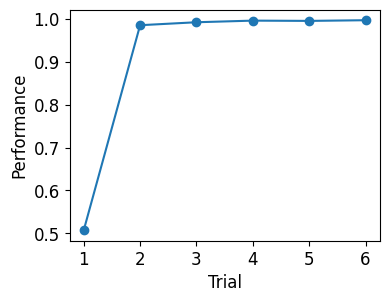

In [5]:
# compute accuracies
accuracies = (data['actions'] == data['correct_answers']).astype(int)

# get intices where there is no change in the first 6 trials
indices = np.all(data['correct_answers'][:, :6] == data['correct_answers'][:, 0][:, None], axis = 1)

# average accuracies
mean_accuracies = accuracies[indices, :6].mean(axis = 0)

plt.figure(figsize = (4, 3))
plt.plot(np.arange(1, 7), mean_accuracies, marker = 'o')
plt.xticks([1, 2, 3, 4, 5, 6])
plt.xlabel('Trial')
plt.ylabel('Performance')
# plt.show()
plt.savefig(os.path.join(exp_path, 'fig.svg'), bbox_inches = 'tight')